# Quick example

Generating peaks with Spectra and fitting them with JuMP V0.19 or higher

You will also need Optim, install it with "import Pkg; Pkg.add("Optim")"

Charles Le Losq, May 2017; Updated January 2024, April 2025

In [2]:
# using Spectra and Plots for plotting and peak fitting
using Plots, Spectra

# for peak fitting with JuMP
using JuMP, Ipopt

# for Bayesian peak fitting example
using Turing

# we can also use Optim for simple problem (check if you have it installed)
using Optim

# Generating data

We generate three peaks using Spectra's functions:

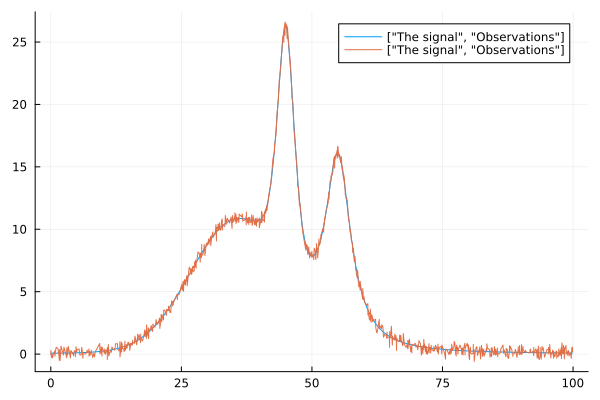

In [3]:
# the X axis, at random values
x_fit = sort(rand(1000)*100)

# the perfect signal
y_fit_perfect = (gaussian(x_fit, [10.0, 35.0, 10.0]) 
+ lorentzian(x_fit, [15.0, 55.0, 3.0]) 
+ pseudovoigt(x_fit, [20.0, 45.0, 2.0, 0.4]))

# real world = noise
noise = randn(length(x_fit))*0.3

# our observation
y_fit = y_fit_perfect + noise

p1 = plot(x_fit, [y_fit_perfect, y_fit], labels= ["The signal", "Observations"])
display(p1)

We can use Spectra.fit_peaks() to fit the signal, given some prior uncertainties on the peak parameters and bounds. Everything is provided in peaks_info below. We also use the Optim.jl backend, with LBFGS and automatic differentiation.

## Peak fitting with Spectra.fit_peaks()

In [4]:
peaks_info = [
    # (type, prior_params, prior_uncertainties, lower_bounds, upper_bounds)
    (:gaussian, [10.5, 30.0, 3.0], [5.0, 10.0, 5.0], [0., 0., 0.], [Inf, Inf, 50.]),
    (:lorentzian, [23.5, 55.0, 3.0], [5.0, 10., 5.0], [0., 0., 0.], [100., 100., 50.]),
    (:pseudovoigt, [16.5, 44.0, 3.0, 0.4], [5.0, 10., 5.0, 0.05], [0., 0., 0., 0.], [100., 100., 50., 1.])
]
result = Spectra.fit_peaks(x_fit, y_fit, peaks_info, sigma=noise, backend=:Optim)

(fit = [0.07015640615846035, 0.07020726534174968, 0.07047558092067442, 0.07081408579830846, 0.071020878574624, 0.07126174372133304, 0.07232489303320967, 0.07234317542969576, 0.07307647127723615, 0.07310591834832116  …  0.08557039546094292, 0.0855320616383681, 0.08512255942978697, 0.08511598264798981, 0.08511055065720143, 0.08402470896346179, 0.08343391528091605, 0.08311844968099098, 0.08269765765221182, 0.08258586494833185], peak_results = Any[(type = :gaussian, params = [10.0136222177448, 34.97236682101899, 9.95583369708472], errors = [0.048417882874335065, 0.10005497777129792, 0.09611597740800783]), (type = :lorentzian, params = [15.058142408997714, 54.99325464545951, 2.994263714940613], errors = [0.07182700978005786, 0.015450511023941396, 0.023076736392538606]), (type = :pseudovoigt, params = [20.07391076576792, 44.99726540635916, 1.9965071767693936, 0.3990612470125305], errors = [0.15715461513785603, 0.00959391552792121, 0.017969577493640882, 0.02828923597003585])], residuals = [-0

We can plot the results:

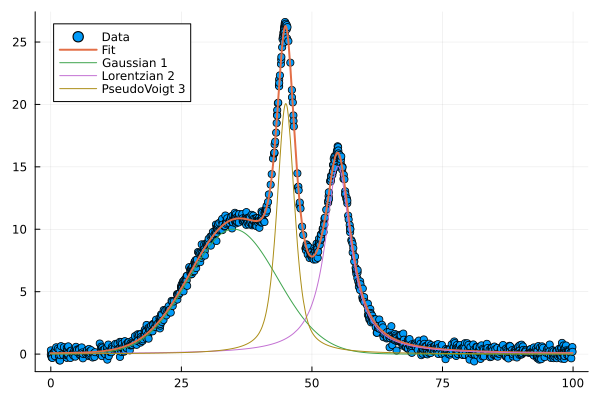

In [9]:
result.plot_fit(components=true)

Also we can print the parameters and calculated errors (using the Hessian):

In [6]:
result.print_params()

Peak 1 (gaussian):
  amplitude: 10.0136 ± 0.0484
  center: 34.9724 ± 0.1001
  width: 9.9558 ± 0.0961
Peak 2 (lorentzian):
  amplitude: 15.0581 ± 0.0718
  center: 54.9933 ± 0.0155
  width: 2.9943 ± 0.0231
Peak 3 (pseudovoigt):
  amplitude: 20.0739 ± 0.1572
  center: 44.9973 ± 0.0096
  width: 1.9965 ± 0.018
  fraction: 0.3991 ± 0.0283


If you want you can adjust the number of digits

In [8]:
result.print_params(digits=3)

Peak 1 (gaussian):
  amplitude: 10.014 ± 0.048
  center: 34.972 ± 0.1
  width: 9.956 ± 0.096
Peak 2 (lorentzian):
  amplitude: 15.058 ± 0.072
  center: 54.993 ± 0.015
  width: 2.994 ± 0.023
Peak 3 (pseudovoigt):
  amplitude: 20.074 ± 0.157
  center: 44.997 ± 0.01
  width: 1.997 ± 0.018
  fraction: 0.399 ± 0.028


## Checking errors with bootstrapping

Spectra.bootsample allows to bootstrap your spectrum and refit the model on data subsamples. This allows to check the errors on parameters!

Let's do that for the first peak:

In [13]:
amp_peak1 = []
pos_peak1 = []
width_peak1 = []
for i = 1:500
    x_boot, y_boot = bootsample(x_fit, y_fit)
    # Define peak information with initial parameters and uncertainties
    peaks_info = [
        (:gaussian, [10.5, 30.0, 3.0], [5.0, 10.0, 5.0], [0., 0., 0.], [Inf, Inf, 50.]),
    (:lorentzian, [23.5, 55.0, 3.0], [5.0, 10., 5.0], [0., 0., 0.], [100., 100., 50.]),
    (:pseudovoigt, [16.5, 44.0, 3.0, 0.4], [5.0, 10., 5.0, 0.05], [0., 0., 0., 0.], [100., 100., 50., 1.])
    ]

    # Perform the fit
    result = fit_peaks(vec(x_boot), vec(y_boot), peaks_info);
    
    append!(amp_peak1, result.peak_results[1][:params][1])
    append!(pos_peak1, result.peak_results[1][:params][2])
    append!(width_peak1, result.peak_results[1][:params][3])
    
end

println(std(amp_peak1))
println(std(pos_peak1))
println(std(width_peak1))

0.02829157020122751
0.0620768599928144
0.07024977106490773


## Using Turing.jl

The same problem can be tackled using Turing.jl and the peak shape functions from Spectra as follow. This offers another way to check that the estimated errors are good for instance:


In [14]:
# Define a Bayesian model with priors
@model function bayesian_peaks(x, y)
    # Define priors based on peak_types
    # Example for a Gaussian peak
    amplitude ~ truncated(Normal(10.5, 5.), 0.0, Inf)
    center ~ Normal(35.0, 10.0)
    width ~ truncated(Normal(10.0, 5.0), 0.0, Inf)

    μ = gaussian(x, [amplitude, center, width])
    
    # PEAK 2
    amplitude2 ~ truncated(Normal(15.5, 5.1), 0.0, Inf)
    center2 ~ Normal(55.0, 10.0)
    width2 ~ truncated(Normal(3.0, 5.0), 0.0, Inf)
    
    μ2 = lorentzian(x, [amplitude2, center2, width2])
    
    # PEAK 3
    amplitude3 ~ truncated(Normal(25.5, 5.1), 0.0, Inf)
    center3 ~ Normal(43.0, 10.0)
    width3 ~ truncated(Normal(2.0, 5.0), 0.0, Inf)
    lr ~ truncated(Normal(0.3, 0.1), 0.0, 1.0)
    
    # Calculate model prediction
    μ3 = pseudovoigt(x, [amplitude3, center3, width3, lr])
    
    # Likelihood
    σ ~ truncated(Normal(0.1, 0.05), 0.01, Inf)
    y ~ MvNormal(μ + μ2 + μ3, σ^2 * I)
end

chain = sample(bayesian_peaks(x_fit, y_fit), NUTS(), 1000, progress=true)

┌ Info: Found initial step size
└   ϵ = 0.0015625
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:08


Chains MCMC chain (1000×23×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 18.69 seconds
Compute duration  = 18.69 seconds
parameters        = amplitude, center, width, amplitude2, center2, width2, amplitude3, center3, width3, lr, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk   ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64     Float64    Float64   Float64    ⋯

   amplitude   17.7770    0.0862    0.0030    852.8867   815.3993    1.0001    ⋯
      center   45.0086    0.0089    0.0003   1081.3243   843.5914    1.0031    ⋯
       width    1.9110    0.0136    0.0005    746.7142   872.9181    1.0037    ⋯
  amplitude2   14.5805    0.0767    0.0028    775.7679   539.463

## JuMP model

In [10]:
nb_peaks = 3 # number of expected peaks
nb_points = size(x,1) # number of data points in the spectrum

# we guess the starting values, not very well...
amp_guess = [5.;25.; ]
pos_guess = [35.;70.]
hw_guess = [10.;25.]

model_ = Model(Ipopt.Optimizer)

# we define the variables with bounds; see documentation of JuMP for details, many things possible!
@variable(model_,0. <= amp[i=1:2] <= 50.,start=amp_guess[i])
@variable(model_,20. <=pos[i=1:2] <= 80.,start=pos_guess[i])
@variable(model_,0. <= hw[i=1:2]  <= 80.,start=hw_guess[i])

# we create an array of gaussian peaks; do not forget that you need to perform point to point calculation
# we cannot use the gaussiennes function there
@NLexpression(model_,gauss[j=1:nb_points,i=1:nb_peaks], amp[i]*exp(-log(2) *((x[j] - pos[i])/hw[i])^2))

@NLobjective(model_, Min,sum((sum(gauss[j,i] for i = 1:nb_peaks)-y_noisy[j])^2 for j =1:nb_points))
optimize!(model_) # solving the model
      
# getting the best parameters
best_amp = value.(amp)
best_pos = value.(pos)
best_hw = value.(hw);

# calculating the model
y_calc, peaks_calc = gaussiennes(best_amp,best_pos,best_hw,x);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       21

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        6
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

In [11]:
println("Parameters calculated by JuMP + Ipopt algo are")
println("Amplitudes: $(best_amp)")
println("Positions: $(best_pos)")
println("Half-Width: $(best_hw)")

Parameters calculated by JuMP + Ipopt algo are
Amplitudes: [9.905260822336466, 19.96702681981043]
Positions: [40.012396974237966, 59.9997666255181]
Half-Width: [9.99244530997909, 4.986136017880759]


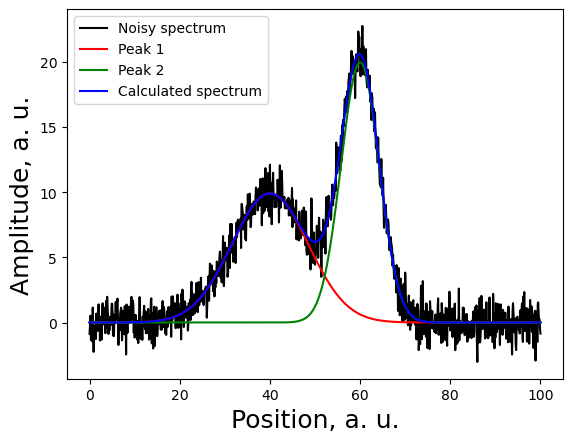

PyObject <matplotlib.legend.Legend object at 0x7f278b453dc0>

In [12]:
figure()
plot(x,y_noisy,"k-",label="Noisy spectrum")
plot(x,peaks_calc[:,1],"r-",label="Peak 1")
plot(x,peaks_calc[:,2],"g-",label="Peak 2")
plot(x,y_calc,"b-",label="Calculated spectrum")

xlabel("Position, a. u.",fontname="Sans",fontsize = 18)
ylabel("Amplitude, a. u.", fontname = "Sans", fontsize = 18)
legend()

- You could also use the LsqFit to fit such an easy case. Here's the way to do it:

Parameters calculated by Optim (Nelder-Mead algo) are
Amplitudes: [19.967034406996227, 9.905265951702138]
Positions: [59.99976084922992, 40.01239333842674]
Half-Width: [4.9861362970808045, 9.992437740447986]


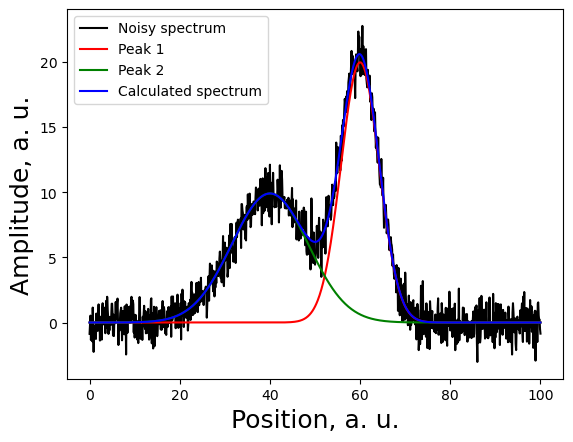

In [17]:
# this funciton will use gaussiennes to construct the model
function model_test(x,p)
    amp = p[1:2]
    pos = p[3:4]
    hw  = p[5:6]
    y, peaks = gaussiennes(amp,pos,hw,x)
    return vec(y)
end

# you define an anonymous function as the pobjective function
objective_function(p) = sum((y_noisy .- model_test(x,p)).^2) # a least square objective function

p0 = [10.;10.;40;50;5.;5.]
Optim_model = Optim.optimize(objective_function,p0,NelderMead())

# getting the best parameters
best_param = Optim.minimizer(Optim_model)

# calculating the model
y_calc_2, peaks_calc_2 = gaussiennes(best_param[1:2],best_param[3:4],best_param[5:6],x)

figure()
plot(x,y_noisy,"k-",label="Noisy spectrum")
plot(x,peaks_calc_2[:,1],"r-",label="Peak 1")
plot(x,peaks_calc_2[:,2],"g-",label="Peak 2")
plot(x,y_calc_2,"b-",label="Calculated spectrum")

xlabel("Position, a. u.",fontname="Sans",fontsize = 18)
ylabel("Amplitude, a. u.", fontname = "Sans", fontsize = 18)
legend()

println("Parameters calculated by Optim (Nelder-Mead algo) are")
println("Amplitudes: $(best_param[1:2])")
println("Positions: $(best_param[3:4])")
println("Half-Width: $(best_param[5:6])")

- We note one bad thing: Optim can return a negative value for one of the half-width... In general, JuMP + Ipopt give very good result and a very high level of control. The drawback is that you have to write down the equations by yourself. On the good side: automatic differentiation is performed...